In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
train_df =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 10_000_000)


In [3]:
test_df = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')

#### We don't need key column for the training dataset

In [4]:
train_df.drop('key', axis=1, inplace=True)

### View and explore the data, check if there are any null values or values that seem out of place

In [5]:
train_df.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [8]:
train_df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [9]:
train_df.isna().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64

In [10]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000000.00000,10000000.00000,10000000.00000,9999931.00000,9999931.00000,10000000.00000
mean,11.33854,-72.50775,39.91934,-72.50897,39.91913,1.68479
std,9.79993,12.99421,9.32254,12.87532,9.23728,1.32342
min,-107.75000,-3439.24506,-3492.26377,-3426.60062,-3488.07951,0.00000
25%,6.00000,-73.99207,40.73491,-73.99139,40.73403,1.00000
50%,8.50000,-73.98181,40.75263,-73.98015,40.75316,1.00000
75%,12.50000,-73.96710,40.76712,-73.96367,40.76810,2.00000
max,1273.31000,3457.62568,3344.45927,3457.62235,3351.40303,208.00000


#### We can see that the minimum fare amount is negative, which can't be correct.
#### Also, the longitudes and latitudes have to be in between [-180, 180] and [-90, 90] respectively.
#### Let's see how many of the values are incorrect.

In [11]:
(train_df['fare_amount'] < 0).sum()

420

In [12]:
((train_df['pickup_longitude'] < -180) | (train_df['pickup_longitude'] > 180)).sum()

218

In [13]:
((train_df['pickup_latitude'] < -90) | (train_df['pickup_latitude'] > 90)).sum()

174

#### We also have to check that the passenger count is between 1 and 6

In [14]:
((train_df['passenger_count'] == 0) | (train_df['passenger_count'] > 6)).sum()

35349

In [15]:
(train_df['passenger_count'] > 6).sum()

17

### There are quite a few entries with passenger count equal to 0, let's check if the test set contains any entries with 0 passenger count.

In [16]:
print("Train Passenger count equals 0: ", (train_df['passenger_count'] == 0).sum())
print("Test Passenger count equals 0: ", (test_df['passenger_count'] == 0).sum())

Train Passenger count equals 0:  35332
Test Passenger count equals 0:  0


### Seeing as there are no entries in the test set with passenger count equal to 0, I'll drop them from the train set in clean_df method below

### Let's explore some of the data visually

#### Check to see how the fare is distributed

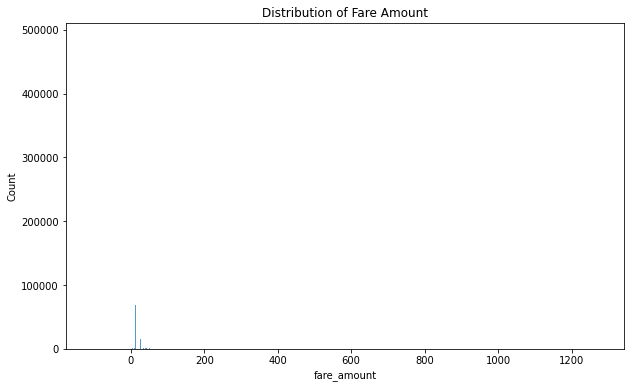

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['fare_amount']);
plt.title('Distribution of Fare Amount');

#### As the fare amounts over 200 are extremely rare, we can drop them as outliers

### We can see that only a small amount of values are labeled incorrectly, removing them from this huge dataset should have no impact.

In [18]:
# def clean_df(df):
#     new_df = df[
#         ((df.fare_amount > 0) & (df['fare_amount'] <= 200)) &
#         ((df['pickup_longitude'] >= -180) & (df['pickup_longitude'] <= 180)) &  
#         ((df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90)) &
#         ((df['passenger_count'] > 0) & (df['passenger_count'] <= 6))
#     ]
    
#     return new_df

### I initally started with the dataframe cleaning method above, however adding in stricter restrictions to longitude and latitude had a significant improvement for the model
### NYC longitude and latitude are (40.7, 70), so I limited the entries to be near the NYC.

In [19]:
def clean_df(df):
    new_df = df[
        ((df['fare_amount'] > 0) & (df['fare_amount'] <= 200)) &
        ((df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)) &  
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) &
        ((df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)) &
        ((df['dropoff_latitude'] > 40 & (df['dropoff_latitude'] < 42))) &
        ((df['passenger_count'] > 0) & (df['passenger_count'] <= 6))
    ]
    
    return new_df

### Here's the visualization of pickup coordinates before and after doing the data cleaning.
### As is visible, before cleaning the data contains lots of absurd values.
### Restricting the coordinates helps the model to learn

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

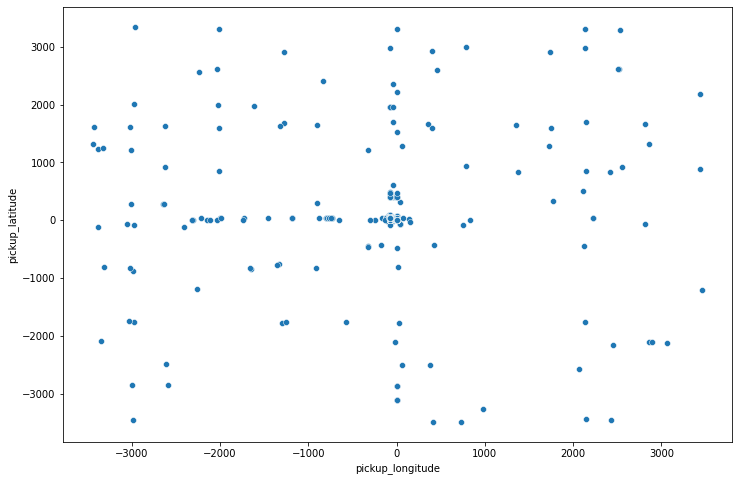

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train_df['pickup_longitude'], y=train_df['pickup_latitude'])

In [21]:
print("Before:", len(train_df))
train_df = clean_df(train_df)
print("After:", len(train_df))


Before: 10000000
After: 9754583


<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

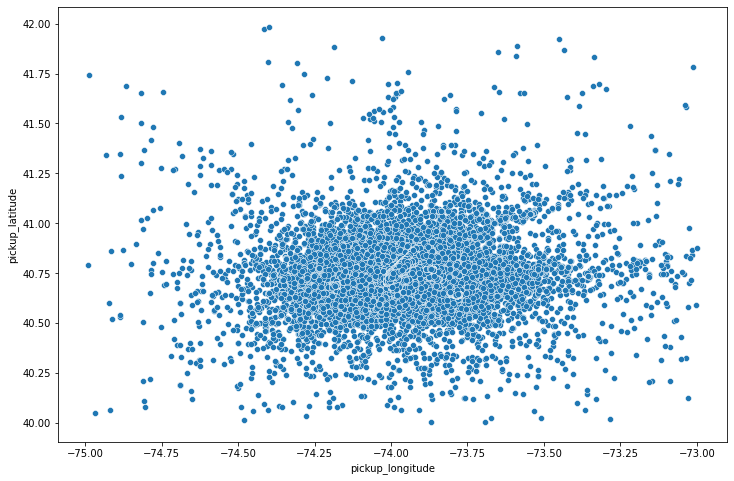

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=train_df['pickup_longitude'], y=train_df['pickup_latitude'])

#### Check to see if there's correlation between the number of passengers and the fare amount

Text(0, 0.5, 'Fare Amount')

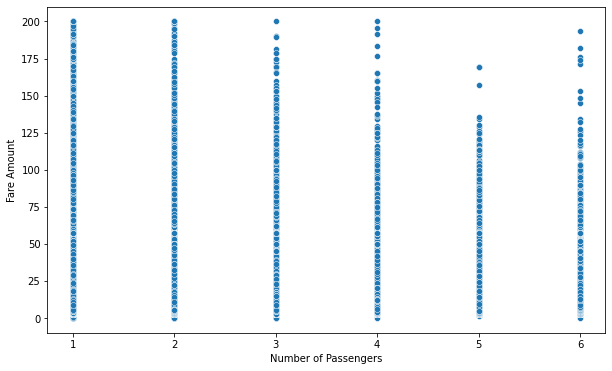

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['passenger_count'], y=train_df['fare_amount'])
plt.xlabel('Number of Passengers')
plt.ylabel('Fare Amount')

#### The fare amount seems to decrease with the increased number of passengers 

In [24]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9754583.00000,9754583.00000,9754583.00000,9754583.00000,9754583.00000,9754583.00000
mean,11.32229,-73.97518,40.75104,-73.97433,40.75225,1.69062
std,9.60933,0.03890,0.03000,0.03802,0.87797,1.30629
min,0.01000,-74.98993,40.00531,-74.99828,0.00026,1.00000
25%,6.00000,-73.99229,40.73655,-73.99158,40.73557,1.00000
50%,8.50000,-73.98210,40.75335,-73.98061,40.75386,1.00000
75%,12.50000,-73.96832,40.76754,-73.96535,40.76840,2.00000
max,200.00000,-73.00002,41.98385,-73.00116,494.65000,6.00000


## Feature Engineering
#### An important metric for the fare amount is the distance travelled
#### Since the earth is almost a sphere, we'll calculate the distances between two points using the haversine formula and add it to our data as a column

In [25]:
# def haversine_distance(lat_p, long_p, lat_d, long_d):
#     R_earth = 6371  #radius of earth in kilometers
    
#     lat_p = np.radians(lat_p)
#     long_p = np.radians(long_p)
#     lat_d = np.radians(lat_d)
#     long_d = np.radians(long_d)
    
#     long_diff = long_d - long_p
#     lat_diff = lat_d - lat_p        
    
#     #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
#     a = np.sin(lat_diff / 2.0) ** 2 + np.cos(lat_p) * np.cos(lat_d) * np.sin(long_diff / 2.0) ** 2
    
#     return 2 * R_earth * np.arcsin(np.sqrt(a))


In [26]:
# lat_p = train_df['pickup_latitude']
# long_p = train_df['pickup_longitude']
# lat_d = train_df['dropoff_latitude']
# long_d = train_df['dropoff_longitude']

# train_df['haversine_dist'] = haversine_distance(lat_p, long_p, lat_d, long_d)


### After experimenting for a while, I found that the manhattan distance formula performs better than the haversine, so I'll be using this for now

In [27]:
def manhattan_dist(lat_p, long_p, lat_d, long_d):  
    distance = np.abs(lat_d - lat_p) + np.abs(long_d - long_p)
    
    return distance

#### Let's extract the information from datetime object, as year, month, day and hour could all be important factors in predicting the fare amount

In [28]:
def add_datetime_info(df, transform_datetime=False):
    if transform_datetime:
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
    
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
#     df['weekday'] = df['pickup_datetime'].dt.weekday # removing this since it's the least important feature
    df.drop('pickup_datetime', axis=1, inplace=True)
        

### The intuition for adding the distances to the airports comes from this great [notebook](https://www.kaggle.com/code/breemen/nyc-taxi-fare-data-exploration)  

In [29]:
def add_airport_info(df):
#     nyc = (40.7141667, -74.0063889)
#     jfk = (-73.7822222222, 40.6441666667)
#     ewr = (-74.175, 40.69)
#     lgr = (-73.87, 40.77)
    
    nyc = (-74.0063889, 40.7141667)
    jfk = (40.6441666667, -73.7822222222)
    ewr = (40.69, -74.175)
    lgr = (40.77, -73.87)
    
    df['distance_to_center'] = manhattan_dist(nyc[0], nyc[1], df['pickup_latitude'], df['pickup_longitude'])
    df['pickup_distance_to_jfk'] = manhattan_dist(jfk[0], jfk[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_jfk'] = manhattan_dist(jfk[0], jfk[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_ewr'] = manhattan_dist(ewr[0], ewr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_ewr'] = manhattan_dist(ewr[0], ewr[1],df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_lgr'] = manhattan_dist(lgr[0], lgr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_lgr'] = manhattan_dist(lgr[0], lgr[1], df['dropoff_latitude'], df['dropoff_longitude'])

    df['long_diff'] = df.dropoff_longitude - df.pickup_longitude
    df['lat_diff'] = df.dropoff_latitude - df.pickup_latitude
    
    

In [30]:
def transform(df, transform_datetime):
    add_datetime_info(df, transform_datetime)
    add_airport_info(df)
    df['manhattan_dist'] = manhattan_dist(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df


### We also need to change the pickup_datetime column from being an object to a datetime object.

In [31]:
# train_df['pickup_datetime'] =  pd.to_datetime(train_df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
train_df = transform(train_df, transform_datetime=True)

In [32]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,4.50000,-73.84431,40.72132,-73.84161,40.71228,1,17,15,6,2009,229.28619,0.13924,0.12750,0.36201,0.35567,0.07437,0.08611,0.00270,-0.00904,0.01174
1,16.90000,-74.01605,40.71130,-73.97927,40.78200,1,16,5,1,2010,229.44791,0.30096,0.33488,0.18026,0.28774,0.20474,0.12127,0.03678,0.07070,0.10748
2,5.70000,-73.98274,40.76127,-73.99124,40.75056,2,0,18,8,2011,229.46456,0.31762,0.31542,0.26353,0.24432,0.12147,0.14068,-0.00850,-0.01071,0.01921
3,7.70000,-73.98713,40.73314,-73.99157,40.75809,1,4,21,4,2012,229.44083,0.29388,0.32327,0.23101,0.25152,0.15399,0.13348,-0.00444,0.02495,0.02939
4,5.30000,-73.96810,40.76801,-73.95665,40.78376,1,7,9,3,2010,229.45666,0.30971,0.31403,0.28491,0.31211,0.10009,0.10042,0.01144,0.01575,0.02719


## I want to add some more Visualizations to see how the fare amount is changing with regards to different time periods.

In [33]:
def visualize_date_fare(df):
#     date_objects = ['hour', 'day', 'weekday', 'month', 'year']
    date_objects = ['hour', 'day', 'month', 'year']

    for idx, obj in enumerate(date_objects):
    #     print("IDX", idx)
    #     print("OBJ", obj)
        plt.figure(figsize=(10,6))
        sns.barplot(x=df[obj], y=df['fare_amount'], ci=None) # setting ci=None dramatically decreases the time for plotting
        print(plt.get_cmap())
        plt.title('Average Fare Amount by ' + obj)
        plt.ylabel('Fare Amount')
        
        plt.show()


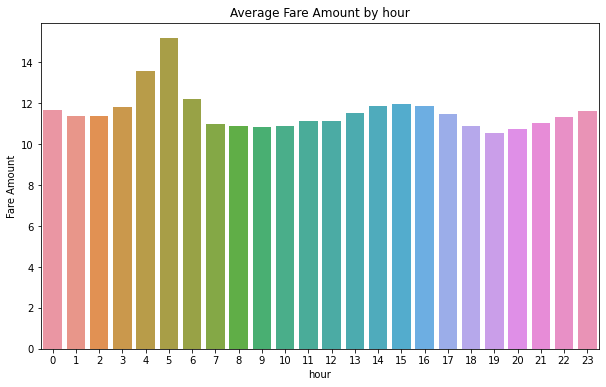

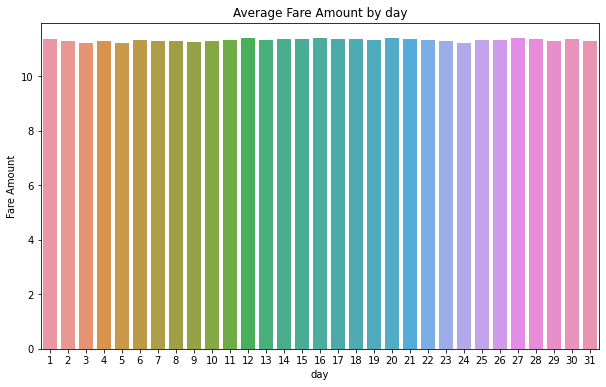

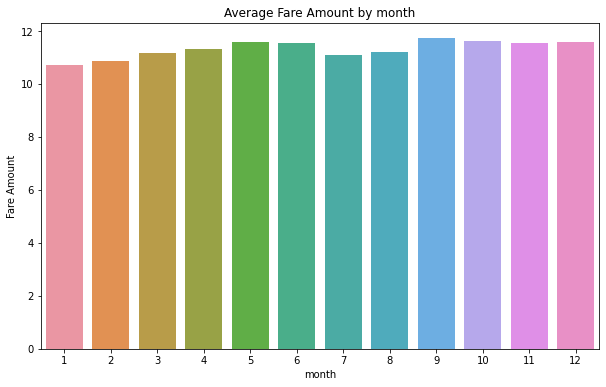

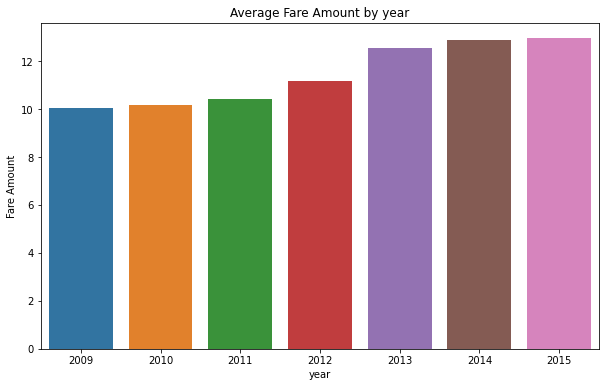

In [34]:
visualize_date_fare(train_df)

### There is a steady trend of increasing fare amounts by the year. We can see the fare amount also changes noticeably by the hour.
### However, the fare amount doesn't seem to change that much from day to day.

In [35]:
def visualize_date_counts(df):
    #     date_objects = ['hour', 'day', 'weekday', 'month', 'year']
    date_objects = ['hour', 'day', 'month', 'year']
    # fig, axes = plt.subplots(1, 5)

    for obj in date_objects:
        plt.figure(figsize=(10,6))
        sns.countplot(x=df[obj])
        plt.ylabel('Count')
        plt.title('Taxi Rides Count by ' + obj)
        plt.show()

### Graphs of the amount of taxi rides by time periods

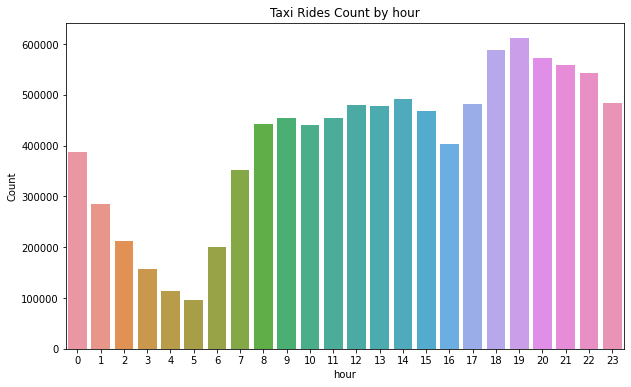

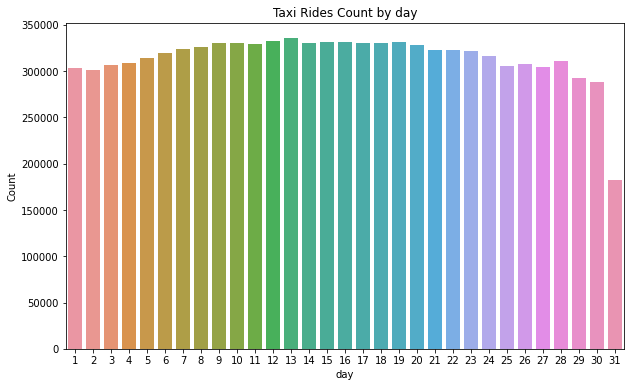

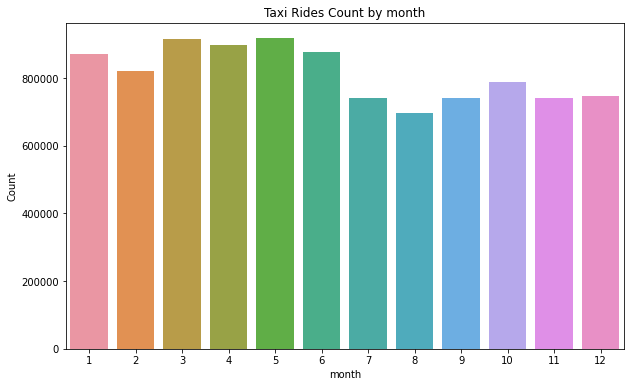

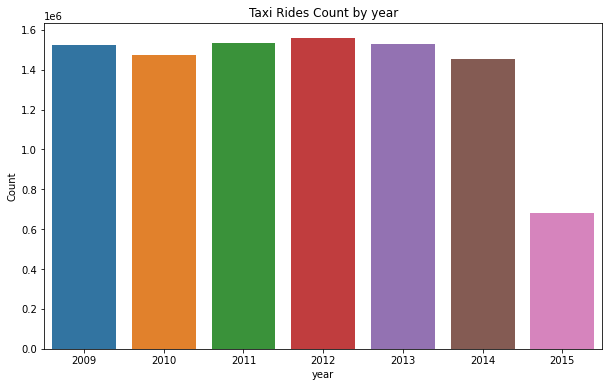

In [36]:
visualize_date_counts(train_df)

In [37]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,4.50000,-73.84431,40.72132,-73.84161,40.71228,1,17,15,6,2009,229.28619,0.13924,0.12750,0.36201,0.35567,0.07437,0.08611,0.00270,-0.00904,0.01174
1,16.90000,-74.01605,40.71130,-73.97927,40.78200,1,16,5,1,2010,229.44791,0.30096,0.33488,0.18026,0.28774,0.20474,0.12127,0.03678,0.07070,0.10748
2,5.70000,-73.98274,40.76127,-73.99124,40.75056,2,0,18,8,2011,229.46456,0.31762,0.31542,0.26353,0.24432,0.12147,0.14068,-0.00850,-0.01071,0.01921
3,7.70000,-73.98713,40.73314,-73.99157,40.75809,1,4,21,4,2012,229.44083,0.29388,0.32327,0.23101,0.25152,0.15399,0.13348,-0.00444,0.02495,0.02939
4,5.30000,-73.96810,40.76801,-73.95665,40.78376,1,7,9,3,2010,229.45666,0.30971,0.31403,0.28491,0.31211,0.10009,0.10042,0.01144,0.01575,0.02719


## Training

### XGBoost's feature importance showed that the passenger count was the lowest feature in terms of importance.
### This aligns with the NYC government's official website, which states that ["There is no extra charge for extra passengers"](http://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)
### Bearing that in mind, I dropped the passenger count feature from the dataset.

In [38]:
# X = train_df.drop(['fare_amount', 'passenger_count'], axis=1)
# y = train_df['fare_amount']

X = train_df.drop(['fare_amount'], axis=1)
y = train_df['fare_amount']

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.05)

In [40]:
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
9862035,-73.97781,40.74659,-73.96574,40.76401,3,11,4,11,2011,229.44496,0.29802,0.30336,0.25378,0.28327,0.13122,0.10173,0.01207,0.01742,0.02949
7658442,-73.98274,40.76411,-73.97974,40.75613,1,19,27,5,2011,229.46740,0.32046,0.30948,0.26637,0.26139,0.11863,0.12361,0.00299,-0.00798,0.01098
934617,-73.95678,40.78007,-73.96651,40.76727,1,14,25,1,2010,229.45741,0.31046,0.30739,0.30829,0.28576,0.09685,0.09924,-0.00973,-0.01280,0.02253
4822154,-73.98793,40.72309,-73.97712,40.75202,1,7,11,5,2011,229.43157,0.28463,0.30274,0.22015,0.25990,0.16484,0.12510,0.01081,0.02893,0.03974
7110616,-73.97765,40.75774,-73.96173,40.77977,1,12,26,12,2014,229.45595,0.30900,0.31511,0.26509,0.30304,0.11991,0.10150,0.01592,0.02203,0.03795


In [41]:
del(X)
del(y)

## Commented because training takes too long during submit, commented on the results below

## Linear Regression

In [42]:
# from sklearn.linear_model import LinearRegression

# reg_model = Pipeline((
#         ("standard_scaler", StandardScaler()),
#         ("lin_reg", LinearRegression()),
#     ))
# reg_model.fit(X_train, y_train)

# y_train_pred = reg_model.predict(X_train)
# y_val_pred = reg_model.predict(X_val)

# print("Linear Regression Train RMSE: ", np.sqrt(mse(y_train, y_train_pred)))
# print("Linear Regression Validation RMSE: ", np.sqrt(mse(y_val, y_val_pred)))


## Random Forest

In [43]:
# from sklearn.ensemble import RandomForestRegressor

# reg_model = Pipeline((
#         ("standard_scaler", StandardScaler()),
#         ("lin_reg", RandomForestRegressor(max_depth=2, random_state=42, n_jobs=-1, verbose=True, n_estimators=100)),
#     ))
# reg_model.fit(X_train, y_train)

# y_train_pred = reg_model.predict(X_train)
# y_val_pred = reg_model.predict(X_val)

# print("Random Forest Train RMSE: ", np.sqrt(mse(y_train, y_train_pred)))
# print("Random Forest Validation RMSE: ", np.sqrt(mse(y_val, y_val_pred)))



## Extreme Gradient Boosting (XGBoost)

### Parameter tuning was taking too long, so I used parameters from [this](https://www.kaggle.com/code/btyuhas/bayesian-optimization-with-xgboost) notebook, played around for a while and these turned out to work pretty well.

In [44]:
def XGBoost(X_train,X_test,y_train,y_test):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)

    return xgb.train(params={'objective':'reg:linear','eval_metric':'rmse', 'max_depth':7, 'colsample_bytree':0.9, 'gamma':1}
                    ,dtrain=dtrain,num_boost_round=400, 
                    early_stopping_rounds=30,evals=[(dtest,'test')])

In [45]:
xgb_model = XGBoost(X_train, X_val, y_train, y_val)

[19:38:43] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:10.57464
[1]	test-rmse:7.96779
[2]	test-rmse:6.28254
[3]	test-rmse:5.24901
[4]	test-rmse:4.63494
[5]	test-rmse:4.27956
[6]	test-rmse:4.07967
[7]	test-rmse:3.97116
[8]	test-rmse:3.89294
[9]	test-rmse:3.84794
[10]	test-rmse:3.80728
[11]	test-rmse:3.78454
[12]	test-rmse:3.76426
[13]	test-rmse:3.74928
[14]	test-rmse:3.74299
[15]	test-rmse:3.73065
[16]	test-rmse:3.71714
[17]	test-rmse:3.71179
[18]	test-rmse:3.69558
[19]	test-rmse:3.68859
[20]	test-rmse:3.68002
[21]	test-rmse:3.66678
[22]	test-rmse:3.66300
[23]	test-rmse:3.66022
[24]	test-rmse:3.65448
[25]	test-rmse:3.64918
[26]	test-rmse:3.64625
[27]	test-rmse:3.63708
[28]	test-rmse:3.62997
[29]	test-rmse:3.62049
[30]	test-rmse:3.61758
[31]	test-rmse:3.61644
[32]	test-rmse:3.61470
[33]	test-rmse:3.61045
[34]	test-rmse:3.60669
[35]	test-rmse:3.60315
[36]	test-rmse:3.60090
[37]	test-rmse:3.59837
[38]	test-rmse:3

In [46]:
y_train_pred = xgb_model.predict(xgb.DMatrix(X_train), ntree_limit = xgb_model.best_iteration)
y_val_pred = xgb_model.predict(xgb.DMatrix(X_val), ntree_limit = xgb_model.best_iteration)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:93: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [47]:
print("Train set error: ", np.sqrt(mse(y_train, y_train_pred)))
print("Validation set error: ", np.sqrt(mse(y_val, y_val_pred)))


Train set error:  3.1490281686166424
Validation set error:  3.4571341119704186


## As expected, the linear model performs the worst on both train and validation sets. The XGBoost outperforms the Random Forest model, however I haven't done any parameter tuning on it so the actual results might be closer.

In [48]:
#Read and preprocess test set
test_df =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
# test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
test_df = transform(test_df, transform_datetime=True)
# test_df['manhattan_dist'] = manhattan_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
#                                    test_df['dropoff_latitude'] , test_df['dropoff_longitude'])



test_key = test_df['key']
# x_pred = test_df.drop(columns=['key', 'passenger_count'])
x_pred = test_df.drop(columns=['key'])

# Predict from test set
prediction = xgb_model.predict(xgb.DMatrix(x_pred))


In [49]:
test_df.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,2015-01-27 13:08:24.0000002,-73.97332,40.76381,-73.98143,40.74384,1,13,27,1,2015,229.45768,0.31074,0.29888,0.27549,0.24741,0.10951,0.13759,-0.00811,-0.01997,0.02808
1,2015-01-27 13:08:24.0000003,-73.98686,40.71938,-73.99889,40.73920,1,13,27,1,2015,229.42680,0.27986,0.31170,0.21752,0.22531,0.16748,0.15969,-0.01202,0.01982,0.03184
2,2011-10-08 11:53:44.0000002,-73.98252,40.75126,-73.97965,40.74614,1,11,8,10,2011,229.45434,0.30740,0.29940,0.25374,0.25149,0.13126,0.13351,0.00287,-0.00512,0.00799
3,2012-12-01 21:12:12.0000002,-73.98116,40.76781,-73.99045,40.75164,1,21,1,12,2012,229.46952,0.32258,0.31569,0.27165,0.24619,0.11335,0.13881,-0.00929,-0.01617,0.02546
4,2012-12-01 21:12:12.0000003,-73.96605,40.78977,-73.98856,40.74443,1,21,1,12,2012,229.47638,0.32943,0.30660,0.30873,0.24086,0.11582,0.14414,-0.02252,-0.04535,0.06787


In [50]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,long_diff,lat_diff,manhattan_dist
0,4.50000,-73.84431,40.72132,-73.84161,40.71228,1,17,15,6,2009,229.28619,0.13924,0.12750,0.36201,0.35567,0.07437,0.08611,0.00270,-0.00904,0.01174
1,16.90000,-74.01605,40.71130,-73.97927,40.78200,1,16,5,1,2010,229.44791,0.30096,0.33488,0.18026,0.28774,0.20474,0.12127,0.03678,0.07070,0.10748
2,5.70000,-73.98274,40.76127,-73.99124,40.75056,2,0,18,8,2011,229.46456,0.31762,0.31542,0.26353,0.24432,0.12147,0.14068,-0.00850,-0.01071,0.01921
3,7.70000,-73.98713,40.73314,-73.99157,40.75809,1,4,21,4,2012,229.44083,0.29388,0.32327,0.23101,0.25152,0.15399,0.13348,-0.00444,0.02495,0.02939
4,5.30000,-73.96810,40.76801,-73.95665,40.78376,1,7,9,3,2010,229.45666,0.30971,0.31403,0.28491,0.31211,0.10009,0.10042,0.01144,0.01575,0.02719


In [51]:
len(x_pred)

9914

In [52]:
prediction = prediction.round(2)

In [53]:
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

# submission.to_csv('/kaggle/working/XGBSubmission.csv',index=False)
submission.to_csv('submission.csv',index=False)
        

In [54]:
pd.read_csv('submission.csv').head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.15000
1,2015-01-27 13:08:24.0000003,10.19000
2,2011-10-08 11:53:44.0000002,4.67000
3,2012-12-01 21:12:12.0000002,8.71000
4,2012-12-01 21:12:12.0000003,15.93000


Plotting Feature Importance


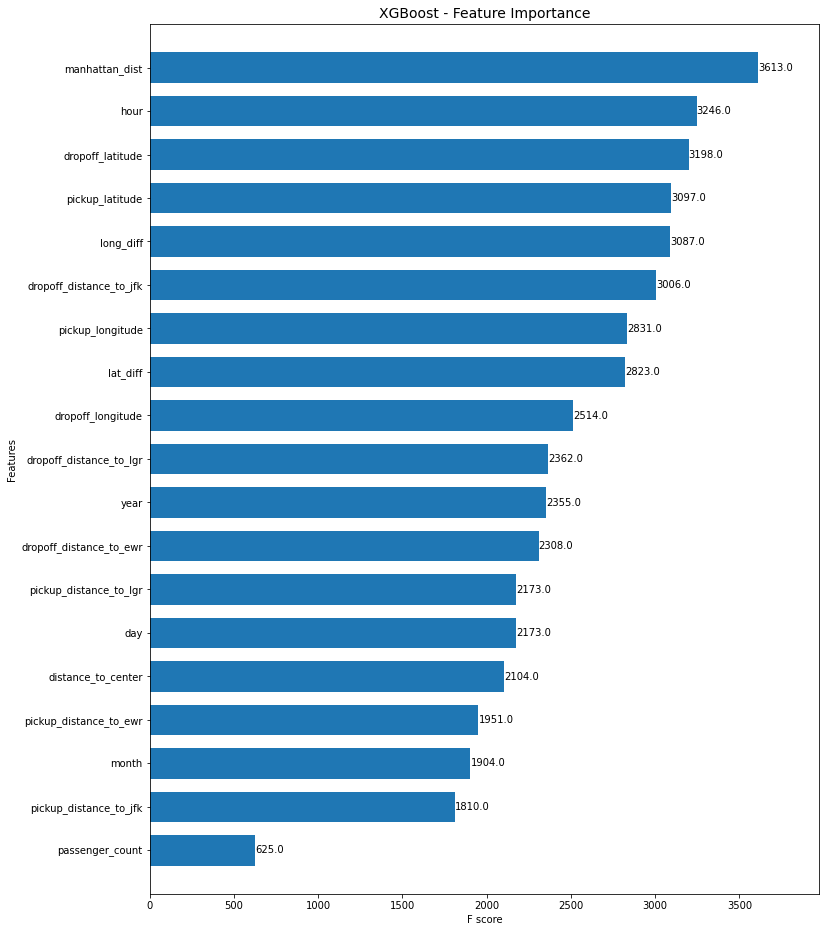

In [55]:
print('Plotting Feature Importance')
fig, ax = plt.subplots(figsize=(12,16))
xgb.plot_importance(xgb_model, height=0.7, ax=ax)
ax.grid(False)
plt.title("XGBoost - Feature Importance", fontsize=14)
plt.show()

## Possible Improvements:
* ### Train with more data, currently I use 10 million examples
* ### Tune hyperparameters using Cross Validation.
* ### Could take real life New York taxi fares in account, for example currently initial charge for taxis in NYC is 2.5$.
* ### Could take holidays and special occations in account, since the tax fares are higher on those days